# Chapter 03: Foundational Components of Neural Networks


In [1]:
import torch
import numpy as np
import torch.nn as nn

class Perceptron(nn.Module):
    """ A perceptron is one linear layer """
    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
       
    def forward(self, x_in):
        """The forward pass of the perceptron
        
        Args:
            x_in (torch.Tensor): an input data tensor 
                x_in.shape should be (batch, num_features)
        Returns:
            the resulting tensor. tensor.shape should be (batch,).
        """
        return torch.sigmoid(self.fc1(x_in)).squeeze()

PyTorch conveniently offers a Linear class in the `torch.nn` module that does the bookkeeping needed for the weights and biases, and does the needed affine transform In “Diving Deep into Supervised Training”, you’ll see how to “learn” the values of the weights w and b from data. The activation function used in the preceding example is the sigmoid function. In the following section, we review some common activation functions, including this one.

## Activation Functions
### Sigmoid

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

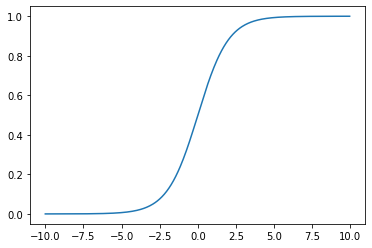

In [2]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt

x = torch.arange(-10., 10., 0.05)
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())


## Tanh


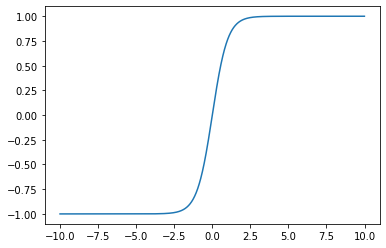

In [3]:
x = torch.arange(-10, 10, 0.01)
y = torch.tanh(x)

plt.plot(x.numpy(), y.numpy())

## ReLU (Rectified Linear Unit)

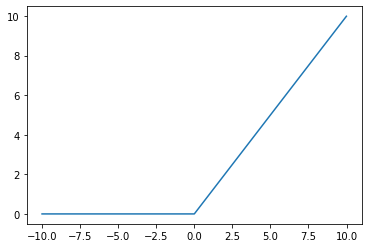

In [4]:
x = torch.arange(-10, 10, 0.01)
y = torch.relu(x)

plt.plot(x.numpy(), y.numpy())

### Softmax

$$
softmax(X)_i = \frac{e^{x_i}}{\sum\limits_{j=1}^{N} e^{x_j}}
$$

In [5]:
import torch.nn as nn
import torch

softmax = nn.Softmax(dim=1)
x_input = torch.randn(1, 3)
y_output = softmax(x_input)
print("Input :", x_input)
print("Output :", y_output)
print(torch.sum(y_output, dim=1))

Input : tensor([[ 0.9958, -2.4724, -0.5679]])
Output : tensor([[0.8061, 0.0251, 0.1688]])
tensor([1.0000])


## Loss functions

### Mean Squared Error

In [6]:

mse_loss = nn.MSELoss()
outputs = torch.randn(2, 2, requires_grad=True)
targets = torch.randn(2, 2)

loss = mse_loss(outputs, targets)
print(loss)

tensor(0.5191, grad_fn=<MseLossBackward>)


### Cross Entropy

To improve numerical stability, `ce_loss` combines softmax and cross entropy.

In this example, outputs are the logits of the softmax function...

In [7]:
ce_loss = nn.CrossEntropyLoss()
outputs = torch.randn(3, 5, requires_grad=False)
targets = torch.tensor([1, 0, 4], dtype=torch.int64)
loss = ce_loss(outputs, targets)
print(loss)

tensor(1.3797)


In [8]:
outputs, targets

(tensor([[-1.1315,  2.1370,  1.2254, -1.6741,  0.7809],
         [ 0.7776,  0.3499, -0.3673, -0.4899,  1.2186],
         [ 0.7291,  0.5494,  0.1505, -0.2311, -0.3989]]), tensor([1, 0, 4]))

### Binary Cross Entropy

In [9]:
bce_loss = nn.BCELoss()

sigmoid = nn.Sigmoid()

probabilities = sigmoid(torch.randn(4, 1, requires_grad=True))
targets = torch.tensor([1, 0, 1, 0],  dtype=torch.float32).view(4, 1)

loss = bce_loss(probabilities, targets)
print(probabilities)
print(loss)

tensor([[0.3736],
        [0.4755],
        [0.5235],
        [0.8855]], grad_fn=<SigmoidBackward>)
tensor(1.1111, grad_fn=<BinaryCrossEntropyBackward>)


## Get Toy Data Function

In [10]:
LEFT_CENTER = (3, 3)
RIGHT_CENTER = (3, -2)

def get_toy_data(batch_size, left_center=LEFT_CENTER, right_center=RIGHT_CENTER):
    """
    Generates batch_size gaussian-distributed points.
    Negative-class points are centered at left_center
    Positive-class points are centered at right_center
    """
    x_data = []
    y_targets = np.zeros(batch_size)
    for batch_i in range(batch_size):
        if np.random.random() > 0.5:
            x_data.append(np.random.normal(loc=left_center))
        else:
            x_data.append(np.random.normal(loc=right_center))
            y_targets[batch_i] = 1
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.float32)

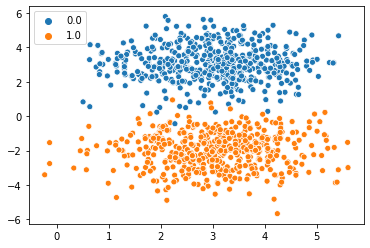

In [11]:
import seaborn as sns

X, y = get_toy_data(1000)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

In [12]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    y_pred = perceptron(x_data)
    y_pred = (y_pred > 0.5).long().data.numpy().astype(np.int32)

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy().astype(np.int32)

    n_classes = 2

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ['black', 'white']
    markers = ['o', '*']
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
        
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=300)
    
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
            
    # hyperplane
    
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    Z = perceptron(torch.tensor(xy, dtype=torch.float32)).detach().numpy().reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=levels, linestyles=linestyles)    
    
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

Let's set some parameters:

- `batch_size`: the size of the batch
- `n_batches`: for each epoch, how many batches should we process?
- `n_epochs`: how many epochs to run

`seed` is set to make this reproducible

In [13]:
batch_size = 1000
n_epochs = 12
n_batches = 5

seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

Create the model and the optimizer

In [14]:
from torch import optim

perceptron = Perceptron(input_dim=2)
optimizer = optim.Adam(params=perceptron.parameters(), lr=0.01)
bce_loss = nn.BCELoss()

Create the data and show the decision boundary of the model

(-0.7843801010444577, 6.43765976317672, -5.740153568028475, 6.19190116526804)

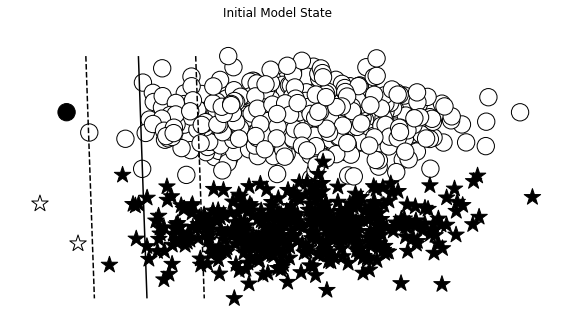

In [15]:
losses = []

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, title='Initial Model State')
plt.axis('off')


Now: train the perceptron until it changes very slightly, or until `n_epochs` epochs are completed

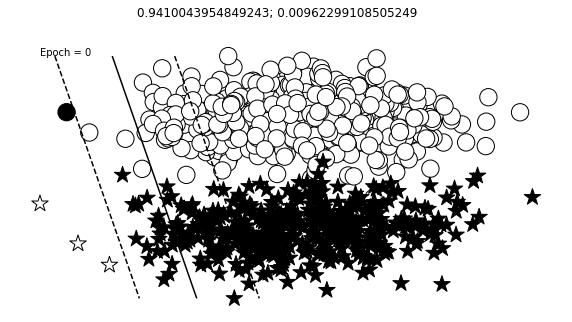

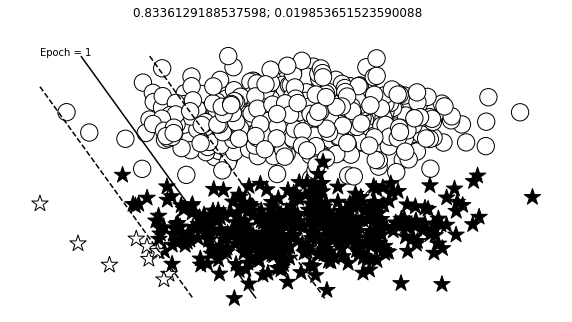

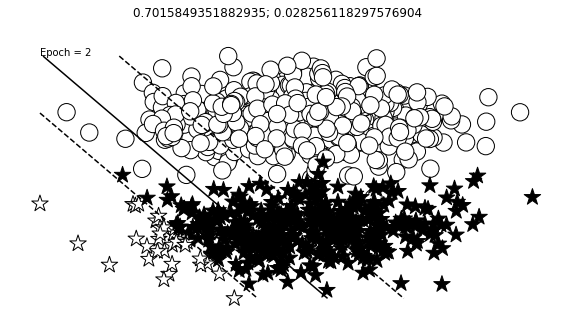

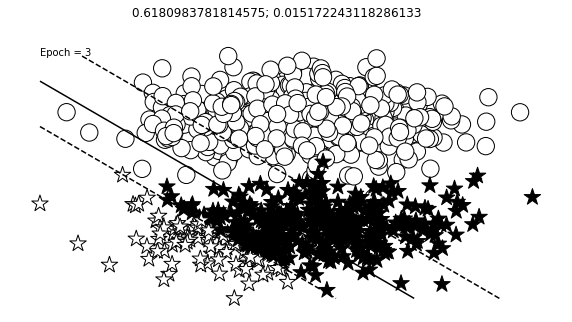

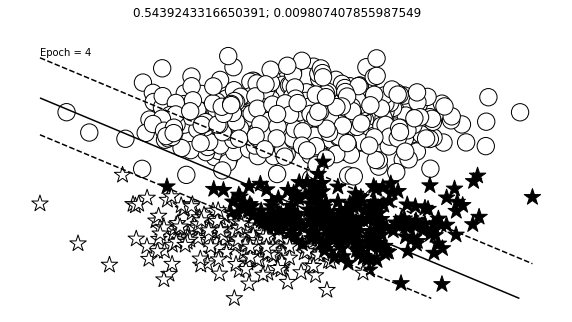

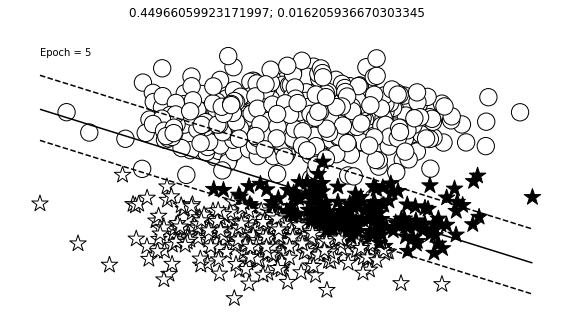

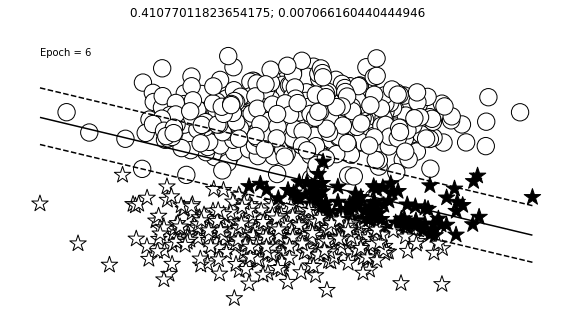

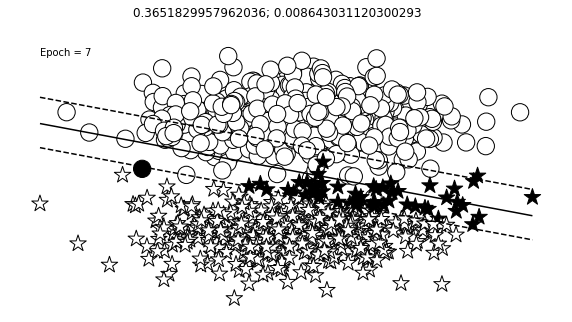

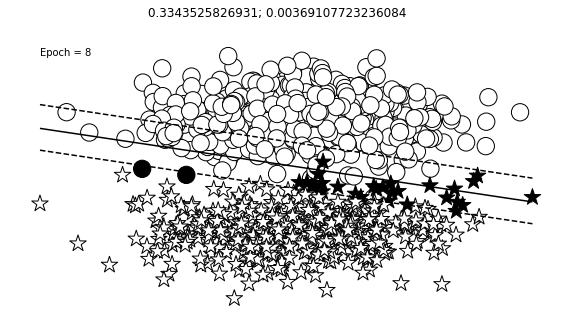

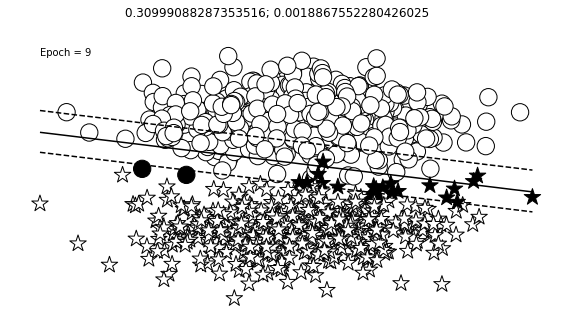

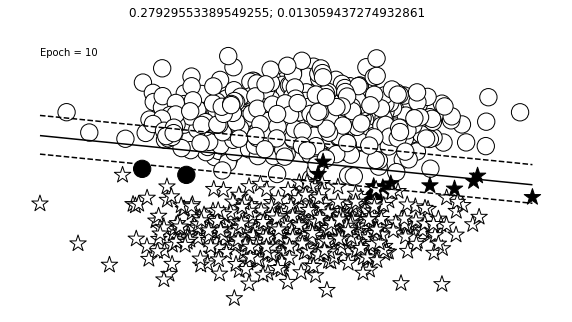

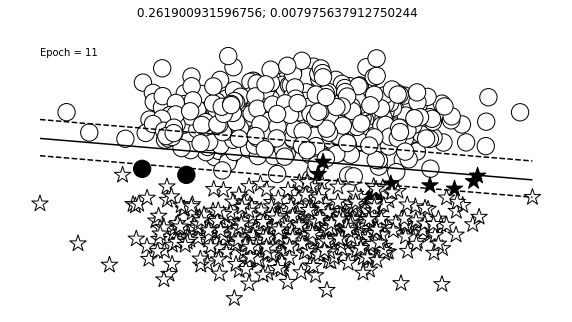

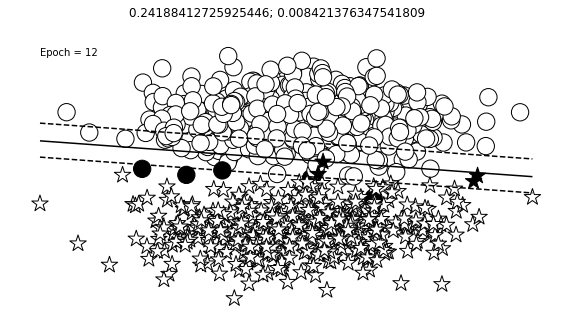

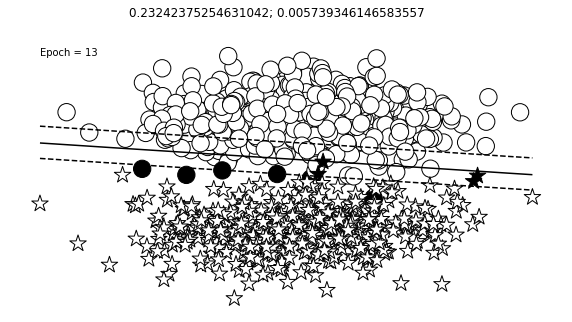

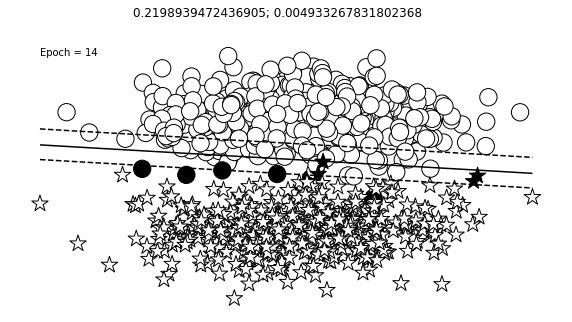

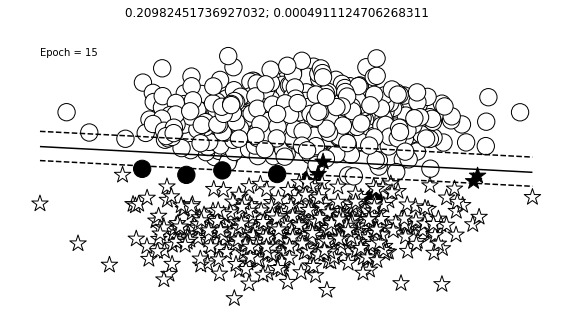

In [16]:

change = 1.0
last = 10.0
epsilon = 1e-3
epoch = 0

while change > epsilon or epoch < n_epochs or last > 0.3:
#for epoch in range(n_epochs):
    for _ in range(n_batches):
        # Zero the gradients
        optimizer.zero_grad()
        # Get the batch
        x_data, y_target = get_toy_data(batch_size)
        # Predict
        y_pred = perceptron(x_data).squeeze()
        # Calculate loss
        loss = bce_loss(y_pred, y_target)
        # Do backward propagation
        loss.backward()
        # Optimize one step
        optimizer.step()
        
        
        loss_value = loss.item()
        losses.append(loss_value)

        change = abs(last - loss_value)
        last = loss_value
               
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value}; {change}")
    plt.axis('off')
    epoch += 1

## More clearly...

In [22]:
from torch import optim

perceptron = Perceptron(input_dim=2)
optimizer = optim.Adam(params=perceptron.parameters(), lr=0.01)
bce_loss = nn.BCELoss()

for _ in range(n_epochs):
    for _ in range(n_batches):
        optimizer.zero_grad()
        X, y = get_toy_data(1000)
        y_pred = perceptron.forward(X)
        
        loss = bce_loss(y_pred, y)
        loss.backward()
        
        optimizer.step()